In [21]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import itertools
pd.set_option("display.max_rows", None)

In [8]:
df_gemini = pd.read_csv('/mnt/team/TM_Lab/Tony/wr_new/analysis_scripts/gemap/results/direct_comparisons__22.csv')
df_gemini_sys_prompt = pd.read_csv('/mnt/team/TM_Lab/Tony/wr_new/analysis_scripts/gemap/results/results_gemini_full_sys_1fps.csv')

In [9]:
df_gemini_sys_prompt = df_gemini_sys_prompt.rename(columns={
    'accuracy': 'accuracy_sys',
    'recall_s': 'recall_s_sys',
    'recall_f': 'recall_f_sys',
    'f1-score_s': 'f1-score_s_sys',
    'f1-score_f': 'f1-score_f_sys'
})
df_merged = df_gemini.merge(df_gemini_sys_prompt, on='filename', how='outer')

In [10]:
df_merged["group"] = "Other"
df_merged.loc[(df_merged["phase"] == "Pre_Stroke") | (df_merged["Stroke"] == "n"), "group"] = "Pre_or_NoStroke"
df_merged.loc[(df_merged["phase"] == "early") & (df_merged["Stroke"] == "y"), "group"] = "Early_Stroke"
df_merged.loc[(df_merged["phase"] == "Late") & (df_merged["Stroke"] == "y"), "group"] = "Late_Stroke"

# Filter to only include the three groups
group_order = ["Pre_or_NoStroke", "Early_Stroke", "Late_Stroke"]
df_merged = df_merged[df_merged["group"].isin(group_order)]

MANOVA ANALYSIS: Regular vs System Prompt (Overall - No Groups)

[1] Preparing Data...
--------------------------------------------------------------------------------
Total observations: 56
Samples: 28
Prompt types: ['No_System_Prompt' 'With_System_Prompt']

Summary Statistics by Prompt Type:
                    accuracy            recall_s            recall_f          
                        mean       std      mean       std      mean       std
prompt_type                                                                   
No_System_Prompt    0.665832  0.177346  0.848913  0.202821  0.449588  0.286138
With_System_Prompt  0.740267  0.118881  0.904249  0.134138  0.543121  0.271779

[2] Checking MANOVA Assumptions

2.1. Sample Sizes
--------------------------------------------------------------------------------
prompt_type
No_System_Prompt      28
With_System_Prompt    28
dtype: int64

Note: MANOVA requires adequate sample size. Have n=28 paired observations.

2.2. Normality Tests (Sha

/tmp/ipykernel_2457957/1132032372.py:282: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2457957/1132032372.py:339: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No System\nInstructions', 'With System\nInstructions'], fontsize=11)
/tmp/ipykernel_2457957/1132032372.py:341: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No System\nInstructions',
/tmp/ipykernel_2457957/1132032372.py:282: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2457957/1132032372.py:33

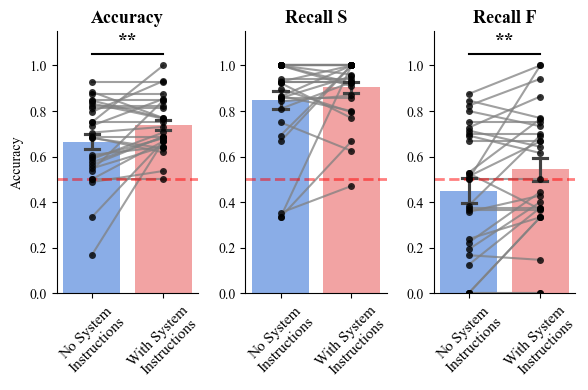


Visualization saved: manova_overall_comparison_connected.png/svg

ANALYSIS COMPLETE


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

print("="*80)
print("MANOVA ANALYSIS: Regular vs System Prompt (Overall - No Groups)")
print("="*80)

# ============================================================================
# 1. PREPARE DATA
# ============================================================================
print("\n[1] Preparing Data...")
print("-"*80)

# Filter groups (optional)
df_merged["group"] = "Other"
df_merged.loc[(df_merged["phase"] == "Pre_Stroke") | (df_merged["Stroke"] == "n"), "group"] = "Pre_or_NoStroke"
df_merged.loc[(df_merged["phase"] == "early") & (df_merged["Stroke"] == "y"), "group"] = "Early_Stroke"
df_merged.loc[(df_merged["phase"] == "Late") & (df_merged["Stroke"] == "y"), "group"] = "Late_Stroke"

group_order = ["Pre_or_NoStroke", "Early_Stroke", "Late_Stroke"]
df_merged = df_merged[df_merged["group"].isin(group_order)]

# Create long format data
df_regular = df_merged[['filename', 'accuracy', 'recall_s', 'recall_f']].copy()
df_regular['prompt_type'] = 'No_System_Prompt'

df_sys = df_merged[['filename', 'accuracy_sys', 'recall_s_sys', 'recall_f_sys']].copy()
df_sys['prompt_type'] = 'With_System_Prompt'
df_sys.columns = ['filename', 'accuracy', 'recall_s', 'recall_f', 'prompt_type']

# Combine
df_long = pd.concat([df_regular, df_sys], ignore_index=True)

# Drop any NaN values
df_long = df_long.dropna(subset=['accuracy', 'recall_s', 'recall_f'])

print(f"Total observations: {len(df_long)}")
print(f"Samples: {len(df_long['filename'].unique())}")
print(f"Prompt types: {df_long['prompt_type'].unique()}")

# Show summary statistics
print("\nSummary Statistics by Prompt Type:")
summary = df_long.groupby('prompt_type')[['accuracy', 'recall_s', 'recall_f']].agg(['mean', 'std'])
print(summary)

# ============================================================================
# 2. CHECK ASSUMPTIONS FOR MANOVA
# ============================================================================
print("\n" + "="*80)
print("[2] Checking MANOVA Assumptions")
print("="*80)

# Assumption 1: Sample sizes
print("\n2.1. Sample Sizes")
print("-"*80)
sample_sizes = df_long.groupby('prompt_type').size()
print(sample_sizes)
print(f"\nNote: MANOVA requires adequate sample size. Have n={len(df_merged)} paired observations.")

# Assumption 2: Multivariate normality
print("\n2.2. Normality Tests (Shapiro-Wilk)")
print("-"*80)

for prompt_type in df_long['prompt_type'].unique():
    print(f"\n{prompt_type}:")
    data = df_long[df_long['prompt_type'] == prompt_type]
    
    for metric in ['accuracy', 'recall_s', 'recall_f']:
        stat, p = stats.shapiro(data[metric])
        sig = "✗ Not normal (p < 0.05)" if p < 0.05 else "✓ Normal (p ≥ 0.05)"
        print(f"  {metric:12s}: W={stat:.4f}, p={p:.4f} {sig}")

print("\nNote: MANOVA is robust to moderate violations of normality with balanced designs.")

# Assumption 3: Homogeneity of covariance matrices
print("\n2.3. Homogeneity of Covariance Matrices")
print("-"*80)

for prompt_type in df_long['prompt_type'].unique():
    print(f"\n{prompt_type}:")
    data = df_long[df_long['prompt_type'] == prompt_type]
    cov = data[['accuracy', 'recall_s', 'recall_f']].cov()
    print(cov)

# Assumption 4: Correlations between DVs
print("\n2.4. Correlations Between Dependent Variables")
print("-"*80)
correlations = df_long[['accuracy', 'recall_s', 'recall_f']].corr()
print(correlations)

print("\nNote: Moderate correlations (0.3-0.7) are ideal for MANOVA.")

# ============================================================================
# 3. PERFORM MANOVA - MAIN EFFECT OF PROMPT TYPE
# ============================================================================
print("\n" + "="*80)
print("[3] MANOVA Results - Main Effect of Prompt Type")
print("="*80)

# Fit MANOVA model (only prompt_type, no group)
formula = 'accuracy + recall_s + recall_f ~ C(prompt_type)'

try:
    manova = MANOVA.from_formula(formula, data=df_long)
    manova_results = manova.mv_test()
    
    print("\nMANOVA Test Results:")
    print(manova_results)
    
    # Interpretation
    print("\n" + "="*80)
    print("Interpretation:")
    print("="*80)
    
    # Extract p-value for prompt_type effect
    if 'C(prompt_type)' in manova_results.results:
        results_table = manova_results.results['C(prompt_type)']['stat']
        
        # Use Wilks' lambda (most common)
        if 'Wilks\' lambda' in results_table.index:
            row = results_table.loc['Wilks\' lambda']
            p_val = row['Pr > F']
            f_val = row['F Value']
            wilks = row['Value']
            
            sig = "✓ SIGNIFICANT (p < 0.05)" if p_val < 0.05 else "✗ Not significant (p ≥ 0.05)"
            
            print(f"\nC(prompt_type):")
            print(f"  Wilks' Lambda: {wilks:.4f}")
            print(f"  F-value: {f_val:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  {sig}")
            
            if p_val < 0.05:
                print(f"\n  → System prompt has a SIGNIFICANT multivariate effect on")
                print(f"     the combined metrics (accuracy, recall_s, recall_f)")
            else:
                print(f"\n  → System prompt does NOT have a significant multivariate effect")
                print(f"     on the combined metrics")
        
        # Also show other multivariate tests
        print("\nOther Multivariate Test Statistics:")
        for test_name in ['Pillai\'s trace', 'Hotelling-Lawley trace', "Roy's greatest root"]:
            if test_name in results_table.index:
                row = results_table.loc[test_name]
                print(f"  {test_name:25s}: Value={row['Value']:.4f}, F={row['F Value']:.4f}, p={row['Pr > F']:.4f}")

except Exception as e:
    print(f"Error running MANOVA: {e}")
    print("\nThis may be due to insufficient sample size or rank deficiency.")

# ============================================================================
# 4. FOLLOW-UP UNIVARIATE TESTS
# ============================================================================
print("\n" + "="*80)
print("[4] Follow-up Univariate Tests")
print("="*80)

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

metrics = ['accuracy', 'recall_s', 'recall_f']
p_values_univariate = []

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-"*80)
    
    # One-way ANOVA: prompt_type only
    formula_anova = f'{metric} ~ C(prompt_type)'
    
    try:
        model = ols(formula_anova, data=df_long).fit()
        anova_table = anova_lm(model, typ=2)
        
        print(anova_table)
        
        # Interpretation
        print("\nInterpretation:")
        
        p_prompt = anova_table.loc['C(prompt_type)', 'PR(>F)']
        f_stat = anova_table.loc['C(prompt_type)', 'F']
        p_values_univariate.append(p_prompt)
        
        sig = "***" if p_prompt < 0.001 else ("**" if p_prompt < 0.01 else ("*" if p_prompt < 0.05 else "ns"))
        
        if p_prompt < 0.05:
            print(f"  ✓ Effect of PROMPT: F={f_stat:.4f}, p={p_prompt:.4f} {sig}")
        else:
            print(f"  ✗ Effect of PROMPT: F={f_stat:.4f}, p={p_prompt:.4f} {sig}")
        
    except Exception as e:
        print(f"Error: {e}")

# Bonferroni correction for multiple univariate tests
print("\n" + "="*80)
print("Multiple Comparison Correction (Bonferroni)")
print("="*80)

reject, p_corrected, _, _ = multipletests(p_values_univariate, alpha=0.05, method='bonferroni')

print(f"\nCorrected α = {0.05/len(metrics):.4f}")

for idx, metric in enumerate(metrics):
    sig = "✓ SIGNIFICANT" if reject[idx] else "✗ Not significant"
    print(f"  {metric:12s}: p_corrected={p_corrected[idx]:.4f} {sig}")

# ============================================================================
# 5. PAIRED COMPARISONS & EFFECT SIZES
# ============================================================================
print("\n" + "="*80)
print("[5] Paired Comparisons & Effect Sizes")
print("="*80)

# Get paired data
regular_data = df_long[df_long['prompt_type'] == 'No_System_Prompt'].set_index('filename')
sys_data = df_long[df_long['prompt_type'] == 'With_System_Prompt'].set_index('filename')

# Find common filenames
common_files = regular_data.index.intersection(sys_data.index)
regular_data = regular_data.loc[common_files]
sys_data = sys_data.loc[common_files]

print(f"\nPaired samples: n={len(common_files)}")

def cohens_d(x1, x2):
    """Calculate Cohen's d for paired samples"""
    diff = x1 - x2
    return diff.mean() / diff.std()

# Store p-values for significance markers
p_values_paired = {}

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-"*80)
    
    # Paired t-test
    t_stat, p_val = ttest_rel(regular_data[metric], sys_data[metric])
    p_values_paired[metric] = p_val
    
    mean_diff = (sys_data[metric] - regular_data[metric]).mean()
    d = cohens_d(sys_data[metric], regular_data[metric])
    
    if abs(d) < 0.2:
        magnitude = "negligible"
    elif abs(d) < 0.5:
        magnitude = "small"
    elif abs(d) < 0.8:
        magnitude = "medium"
    else:
        magnitude = "large"
    
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
    
    print(f"  No System:   mean={regular_data[metric].mean():.3f}, sd={regular_data[metric].std():.3f}")
    print(f"  With System: mean={sys_data[metric].mean():.3f}, sd={sys_data[metric].std():.3f}")
    print(f"  Difference:  Δ={mean_diff:+.3f}")
    print(f"  Paired t-test: t={t_stat:.3f}, p={p_val:.4f} {sig}")
    print(f"  Cohen's d: {d:+.3f} ({magnitude})")

# ============================================================================
# 6. VISUALIZATION WITH CONNECTED DOTS AND SIGNIFICANCE STARS
# ============================================================================
print("\n" + "="*80)
print("[6] Creating Visualization...")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Bar plot
    sns.barplot(
        data=df_long,
        x='prompt_type',
        y=metric,
        order=['No_System_Prompt', 'With_System_Prompt'],
        errorbar='se',
        capsize=0.2,
        palette=['#4285F4', '#FF6B6B'],
        ax=ax,
        alpha=0.7
    )
    
    # Connect dots for each sample (draw BEFORE stripplot so lines are behind)
    for idx_file, row in df_merged.iterrows():
        ax.plot([0, 1], 
               [row[metric], row[f'{metric}_sys']], 
               'gray', alpha=0.75, linewidth=1.5, zorder=1)
    
    # Add stripplot WITHOUT jitter
    sns.stripplot(
        data=df_long,
        x='prompt_type',
        y=metric,
        order=['No_System_Prompt', 'With_System_Prompt'],
        color='black',
        size=5,
        jitter=False,  # No jitter
        alpha=0.8,
        ax=ax,
        zorder=3
    )
    
    # Add significance stars based on paired t-test
    p_val = p_values_paired[metric]
    
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Only add stars if significant
    if p_val < 0.05:
        # Get the y-position for the significance bar
        y_max = df_long[metric].max()
        y_pos = y_max + 0.05
        
        # Draw significance bar
        ax.plot([0, 1], [y_pos, y_pos], 'k-', linewidth=1.5)
        ax.text(0.5, y_pos + 0.02, sig_text, ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_title(metric.replace('_', ' ').title(), fontsize=13, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric.replace('_', ' ').title() if idx == 0 else '')
    ax.set_xticklabels(['No System\nInstructions', 'With System\nInstructions'], fontsize=11)
    ax.set_ylim(0, 1.15)  # Increased to make room for significance markers
    ax.set_xticklabels(['No System\nInstructions', 
                        'With System\nInstructions'], fontsize=11, rotation=45) # or 90 for vertical labels ha='center' # align nicely if rotated )
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('manova_overall_comparison_connected.png', dpi=300, bbox_inches='tight')
plt.savefig('manova_overall_comparison_connected.svg', dpi=1000, bbox_inches='tight')
plt.show()

print("\nVisualization saved: manova_overall_comparison_connected.png/svg")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

In [15]:
import pandas as pd
from functools import reduce

# Base Gemini file (only used for common filenames)
df_gemini = pd.read_csv('./results/direct_comparisons__22.csv')[['filename']]

# FPS files
fps_files = {
    '1fps': './results/results_gemini_full_sys_1fps.csv',
    '2fps': './results/results_gemini_full_sys_2fps.csv',
    '6fps': './results/results_gemini_full_sys_6fps.csv',
    '13fps': './results/results_gemini_full_sys_13fps.csv',
    '27fps': './results/results_gemini_full_sys_27fps.csv',
    '54fps': './results/results_gemini_full_sys_54fps.csv'
}

# Load and rename accuracy columns
dfs = []
for fps, path in fps_files.items():
    df = pd.read_csv(path)[['filename', 'accuracy']]
    df = df.rename(columns={'accuracy': f'accuracy_sys_{fps}'})
    dfs.append(df)

# Merge all fps DataFrames on filename (inner join = only common filenames)
df_merged = reduce(lambda left, right: pd.merge(left, right, on='filename', how='inner'), dfs)

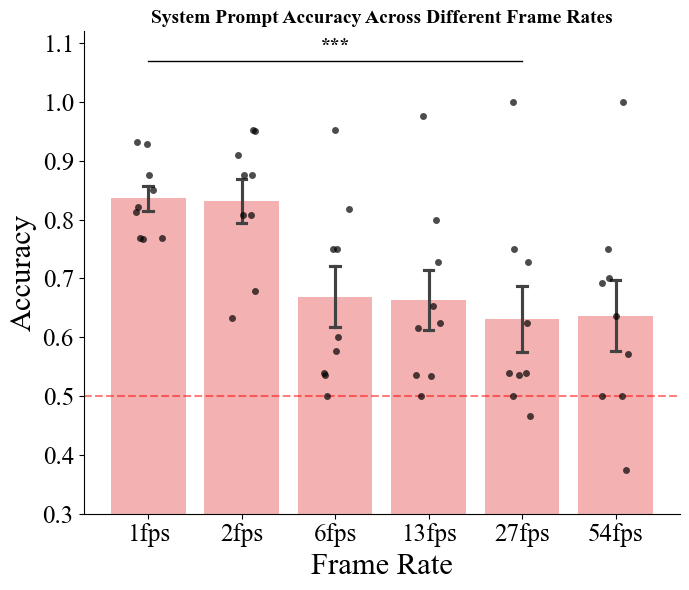

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

df_wide = df_merged.copy()
# Reshape from wide to long format for easier plotting
id_vars = ['filename']
value_vars = [col for col in df_wide.columns if 'accuracy_sys' in col]
df_long = pd.melt(df_wide, id_vars=id_vars, value_vars=value_vars,
                  var_name='frame_rate_label', value_name='Accuracy')

df_long['frame_rate'] = df_long['frame_rate_label'].str.split('_').str[-1]
frame_rate_order = ['1fps', '2fps', '6fps', '13fps', '27fps', '54fps']

# --- 2. Statistical Test (1fps vs 27fps) ---
# Test comparing the highest mean accuracy (1fps) against a high frame rate (27fps)
acc_1fps = df_wide['accuracy_sys_1fps']
acc_27fps = df_wide['accuracy_sys_27fps']

t_stat, p_val = ttest_rel(acc_1fps, acc_27fps)

# --- 3. Plot Generation (Bar plot + Scatter, NO connecting lines) ---
plt.figure(figsize=(7, 6))

bar_color = '#FF6B6B' # Google Blue

# 1. Bar plot (Mean and SE)
sns.barplot(
    data=df_long,
    x='frame_rate',
    y='Accuracy',
    order=frame_rate_order,
    errorbar='se', # Standard Error
    capsize=0.1,
    color=bar_color,
    alpha=0.6,
    zorder=2
)

# 2. Add stripplot (dots) with slight jitter
sns.stripplot(
    data=df_long,
    x='frame_rate',
    y='Accuracy',
    order=frame_rate_order,
    color='black',
    size=5,
    jitter=0.15, # Use jitter to separate overlapping points
    alpha=0.7,
    zorder=3
)

# 3. Add significance star (1fps vs 27fps)
if p_val < 0.05:
    # Determine significance text
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    else:
        sig_text = '*'

    # Calculate bar position (max data point + margin)
    y_max = df_long['Accuracy'].max()
    y_pos = y_max + 0.07

    # Draw significance bar between 1fps (index 0) and 27fps (index 4)
    plt.plot([0, 4], [y_pos, y_pos], 'k-', linewidth=1)
    # Add star centered above the bar
    plt.text(2.0, y_pos + 0.01, sig_text, ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    plt.ylim(0.3, y_pos + 0.05) # Adjust y-limit
else:
    plt.ylim(0.3, 1.05)


# 4. Final plot settings
plt.title('System Prompt Accuracy Across Different Frame Rates', fontsize=14, fontweight='bold')
plt.xlabel('Frame Rate', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.5) # Reference line

sns.despine()
plt.tight_layout()

plt.savefig('accuracy_by_frame_rate_unconnected.svg', dpi=1000)

In [24]:
baseline_column = 'accuracy_sys_1fps'

# The columns to compare against the baseline
comparison_columns = [
    'accuracy_sys_2fps',
    'accuracy_sys_6fps',
    'accuracy_sys_13fps',
    'accuracy_sys_27fps',
    'accuracy_sys_54fps'
]

# Perform and print the results of the paired t-tests
for column in comparison_columns:
    t_statistic, p_value = stats.ttest_rel(df_merged[baseline_column], df_merged[column])
    print(f"Paired t-test for {baseline_column} vs {column}:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}\n")

Paired t-test for accuracy_sys_1fps vs accuracy_sys_2fps:
T-statistic: 0.14218229964141488
P-value: 0.8904515694278103

Paired t-test for accuracy_sys_1fps vs accuracy_sys_6fps:
T-statistic: 4.146965397987543
P-value: 0.003222380394865086

Paired t-test for accuracy_sys_1fps vs accuracy_sys_13fps:
T-statistic: 4.423687185821601
P-value: 0.002215571469179173

Paired t-test for accuracy_sys_1fps vs accuracy_sys_27fps:
T-statistic: 5.0604147460109035
P-value: 0.0009765462671801974

Paired t-test for accuracy_sys_1fps vs accuracy_sys_54fps:
T-statistic: 4.064550980733228
P-value: 0.003610584169748399

